# TL;DR

* I trained Karpathy's nanoGPT, a small GPT using a simple bigram language model and a transformer architecture with multi-head self-attention, on OHLC tick-by-tick stock price data and found that if performs well at volatility prediction, a risk management activity. 

* I convert numbers to text and train the text-to-text nanoGPT to understand the patterns in the data well enough to generate text in the form of OHLC stock price data that can be switched back to numbers and used for complex numeric computations.  

* Under this setup NanoGPT seems to perform well as a volatility predictor, at least as well as number-to-number asset pricing models traditionally used for this task.

# Overview

* In this post, I explore the use of LLMs for tasks that are typically performed by models more specific to asset pricing and risk management. I train Karpathy's __[nanoGPT](https://johncollinsai-nanogpt-voqqf4ls3a-as.a.run.app/)__ on high-frequency (tick-by-tick) data for __[AAPL](https://www.google.com/search?q=aapl&oq=AAPL&aqs=chrome.0.0i512l5j69i61l3.1590j1j9&sourceid=chrome&ie=UTF-8)__ and __[JPM](https://www.google.com/search?q=jpm+stock+price&oq=JPM+stock+pri&aqs=chrome.0.0i512j69i57j0i512l8.4577j1j9&sourceid=chrome&ie=UTF-8)__. I want to see how nanoGPT performs as a volatility predictor.  Volatility prediction is used in risk management to estimate the potential fluctuations in the value of an asset or portfolio over a given period of time. Volatility, the second moment, is a measure of how much the return fluctuates around its mean, and it is a key input in risk management models used by financial institutions and required by regulators. 

* The established model classes for vol prediction include stochastic volatility models such as the __[MSM](https://github.com/johncollinsai/markov-switching-multifractal)__ of Calvet & Fisher, ARCH and GARCH, and Jump Diffusion models. Deep learning is also used for vol prediction and this __[post](https://johncollinsai-deep-learning-finance-voqqf4ls3a-as.a.run.app/)__ provides colour. However, the application of LLMs to this problem is quite novel and the use of nanoGPT provides a great basis for an under-the-hood examination of the application of text-to-text LLMs to numeric problems.

* I begin with __[my earlier implementation of Karpathy's nanoGPT](https://github.com/johncollinsai/nanogpt)__, which I train on a cleansed dataset comprising some 1.079 million rows in total . In order to negate or reduce the impact of microstructure noise, and in particular Bid-Ask bounce, I compute a weighted mid-price using the CloseBid and CloseAsk prices and sizes. I discuss microstructure noise, Bid-Ask bounce, weighted mid-price, and my motivation for using it, in detail in my post __[high frequency data](https://johncollinsai-high-frequency-data-voqqf4ls3a-as.a.run.app)__.  I obtain returns from the WMP and, for tractability, log returns. I present the analysis for AAPL in this post, but I process the data for both securities.  I don't write up JPM here because it gets a bit repetitive, but the results are broadly in line with AAPL.

* As always when working with high-frequency data, I have to do a lot of work up-front to prepare the data.  I also have to devote quite a bit of effort to processing the generated text output from nanoGPT, in order that it can be used for a numeric purpose.

* Roughly speaking my code is organized as follows. The volgpt_import function checks if a GPU is available and prints the device and device name, then calls the high_frequency_data function, which reads AAPL and JPM from 500+ daily NYSE TAQ files and combines the data into a single DataFrame and sets appropriate column names and data types. A DateTimeIndex column is created by combining Date and OpenBarTime, set as the index, then the DataFrame is trimmed to only include relevant columns and computes the WeightedMidPrice. At some stage it may be worth reintroducing a larger set of columns as I suspect that may improve model performance, but will require more data preparation steps on both the input side and with regard to the generated text.  

* The high_frequency_data function splits the data into separate DataFrames for AAPL and JPM, and computes raw returns and log returns for both stocks and merges them into their respective DataFrames. Descriptive statistics are computed using the returns. Specified columns are then formatted with a fixed number of decimal place (this helps greatly with respect to the tractability of the text generated by the model) and missing values replaced with "UNK". Then all columns are converted to strings. The function returns two DataFrames (df_data_AAPL, df_data_JPM), raw returns (AAPL_rr, JPM_rr), log returns (AAPL_lr, JPM_lr), and descriptive statistics (AAPL_stats, JPM_stats) for both stocks.

* The vol_import function identifies and prints any missing values in the AAPL and JPM data, then saves the AAPL and JPM data to text files with a comma delimiter. Finally it checks if the text files were saved correctly by reading them back into dataframes and comparing their shapes with the original data, and returns the AAPL and JPM data, their respective risk ratios, leverage ratios, and statistics.

* The nanoGPT model is written in the volgpt_model.py file.  The train_and_generate function trains the model on a given text file and generates new text. The function accepts several arguments (i.e., text_file_path, the path to the input text file; max_iters, the maximum number of iterations to run the training loop (I set a default: 5000); learning_rate, for the optimizer (default: 1e-3); device, so that operations can be passed to the GPU; and max_new_tokens, the maximum number of new tokens to generate (default: 5000). It then tokenizes the input text, splits it into training, validation, and test sets, and defines a simple bigram language model using Karpathy's transformer architecture with multi-head self-attention. It trains the model in a loop for max_iters iterations and evaluates the loss periodically on the train, validation, and test sets. After training, the function generates new text using the trained model and returns a tuple containing the test data tensor, the generated text, and a mapping from indices to characters (itos).

* Having generated text, it is necessary to clean it and convert it back to numeric form to perform the volatility predictions. The clean_data function takes in high-frequency price data text generated by nanoGPT in the form of text format tabular data, plus an optional column_names parameter. It cleans and validates the input data, ensuring that the date format is correct. I experimented with 3 variants of the date format check (2 are commented out) and all work, though somewhat differently depending upon other settings. It then checks that all numeric values are valid. The function reads the data into a DataFrame, checks the date format, and validates numeric values. It then removes invalid rows and converts the data types of each column appropriately. Finally, the function returns three objects: the original DataFrame, the cleaned DataFrame, and a list of invalid row indices.

* Finally, the function volgpt_stats takes in generated_text, test_data, and the itos mapping, and calculates the statistics for evaluating the performance of nanoGPT's generated text compared to the held-out test data. The function first converts test data tensors to strings using the itos mapping and cleans both the generated text and test data using the clean_data function. Next, it merges the cleaned data based on the 'DateTimeIndex' column and removes rows with spurious values for 'rr_generated' and 'lr_generated'. The function then calculates the Mean Squared Error (MSE) and Mean Absolute Error (MAE) for raw returns (rr) and log returns (lr), as well as paired t-tests for both. The results are printed, and the function returns the cleaned generated data, cleaned test data, merged data, and calculated statistics.

* NanoGPT appears to perform well under this setup. The MSE's (0.05078798 and 0.00000192 respectively) and MAEs (0.17065891 and 0.00099668) are low and paired t-tests (raw returns T-stat = 0.69149665, p-value = 0.50499000 and log returns T-stat = 0.71337283, p-value = 0.49192750) indicate there is no significant difference between predicted and true values. This suggests good predictive performance, but it's difficult to determine the overall quality of the predictions without comparing them to the performance of other models or benchmarks in the same context. 

* I think these results are quite profound because they show that it is possible to convert numbers to text and train a LLM to understand patterns in data that enable forward prediction of volatility with a level accuracy comparible to asset pricing models built specifically for the purpose.  This suggests that LLMs can be used in a variety of ways for asset pricing and risk management.

* I use an NVIDIA GeForce RTX 3080 Ti Laptop GPU and a deep learning framework that includes PyTorch, CUDA, cuDNN, and NVIDIA Drivers, on Ubuntu 22.04 LTS.  Source code as always may be found on __[my GitHub](https://github.com/johncollinsai/volgpt)__.

# Using nanoGPT to solve a number-to-number problem

### Import high-frequency data, prepare, describe and visualize it

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
df_data_AAPL.shape:  (533860, 8)
df_data_JPM.shape:  (537011, 8)
no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values
shape of df_data_AAPL:  (533860, 8)
shape of df_exported_AAPL:  (533860, 9)
shape of df_data_JPM:  (537011, 8)
shape of df_exported_JPM:  (537011, 9)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534

Augmented Dickey-Fuller test for AAPL log returns:
ADF Statistic: -731.091962
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.

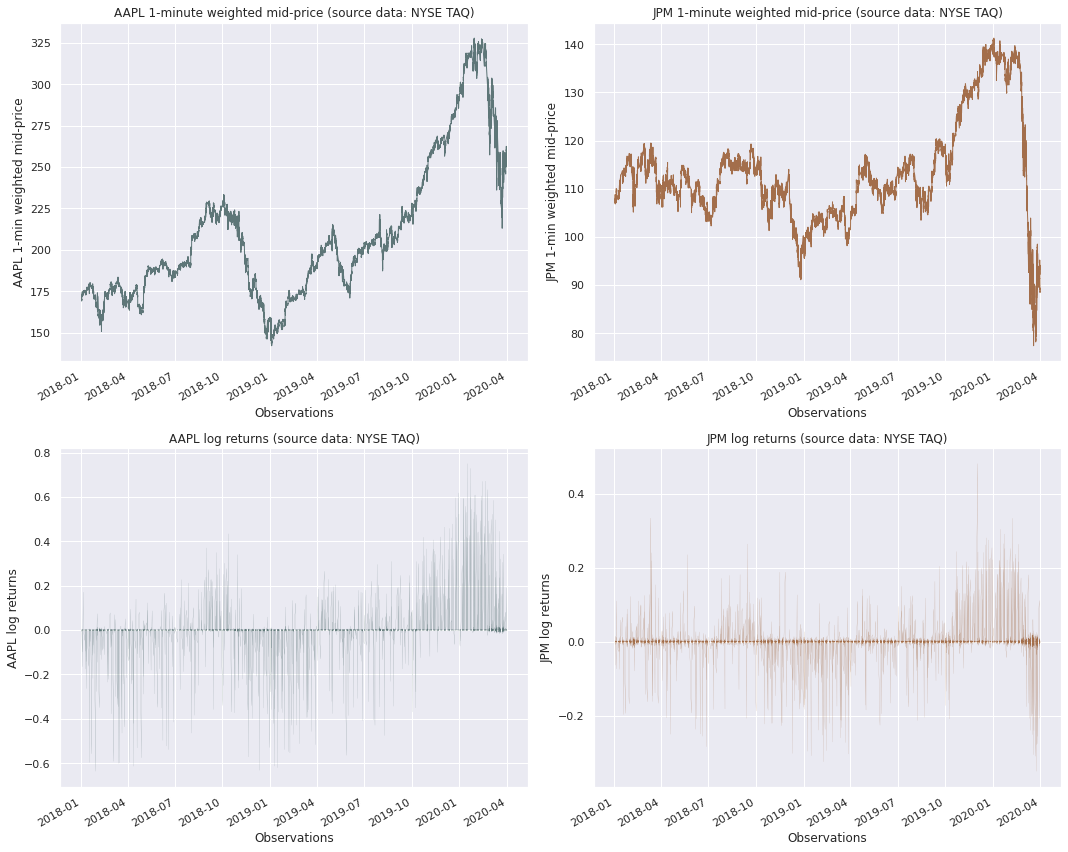

In [1]:
# import the high frequency OHLC data from NYSE TAQ, prepare it
from volgpt_get_and_describe import volgpt_import, volgpt_describe 
df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats, device = volgpt_import(dp=8) # set dp

# describe and visualize the data
volgpt_describe(AAPL_stats, JPM_stats, df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr)

### Observations re prepared high-frequency returns and log returns

* The data illustrates the stylized facts of returns: almost unpredictable, fat tails, and volatility clustering. The mean is close to zero relative to the standard deviations and the standard deviation is high for both AAPL and JPM. The time series includes the start of 2020 and the outbreak of COVID, which saw the highest volatility since the 1920's. This is evident too in the minimum and maximum returns, which are quite far from the mean.  It would be normal to remove outliers in data processing, but I have not done so, in order to make things a bit more difficult for the model.

* ADF test results indicate stationarity. The ADF statistics (-731.091962 and -523.029047) are much lower than the critical values at 1% significance levels, and the p-values are very small (0.000000).

### Train NanoGPT and generate new high-frequency data

* I generate 50k tokens, and then decode the tokens into a string. The output string contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values, as text. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp. After the timestamp, the other text generated by the model shows data separated by commas, following the structure I imposed upon the training text. 

* Note that I generate 50k tokens because I need a lot of generated text to get datetimestamps that align between the generated high frequency data and the real high frequency data.

In [2]:
# Train the model on AAPL and JPM OHLC data and use it to generate high-frequency data in the form of text
from volgpt_model import train_and_generate
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
max_iters = 5000
learning_rate = 1e-4
max_new_tokens=50000 # Set max_new_tokens sufficiently high that date-time stamps match the original data

test_data, generated_text, itos = train_and_generate(text_file_path,
                                                     max_iters=max_iters,
                                                     learning_rate=learning_rate,
                                                     device=device,
                                                     max_new_tokens=max_new_tokens)

# print the first 10 lines of generated text
print('\n'.join(generated_text.splitlines()[:10]))
# print(generated_text)

0.207149 M parameters
step 0: train loss 3.9630, val loss 3.9613, test loss 3.9599
step 100: train loss 1.6206, val loss 1.6177, test loss 1.5886
step 200: train loss 1.1799, val loss 1.1919, test loss 1.1916
step 300: train loss 1.0185, val loss 1.0271, test loss 1.0123
step 400: train loss 0.9441, val loss 0.9492, test loss 0.9446
step 500: train loss 0.9114, val loss 0.9123, test loss 0.9245
step 600: train loss 0.8843, val loss 0.8874, test loss 0.8774
step 700: train loss 0.8742, val loss 0.8835, test loss 0.8753
step 800: train loss 0.8666, val loss 0.8682, test loss 0.8532
step 900: train loss 0.8685, val loss 0.8625, test loss 0.8631
step 1000: train loss 0.8363, val loss 0.8307, test loss 0.8450
step 1100: train loss 0.8358, val loss 0.8436, test loss 0.8334
step 1200: train loss 0.8317, val loss 0.8255, test loss 0.8271
step 1300: train loss 0.8261, val loss 0.8253, test loss 0.8329
step 1400: train loss 0.8269, val loss 0.8153, test loss 0.8282
step 1500: train loss 0.8213, 

### Observations re model training

* Under this set up the model has 0.207149 million parameters, which is of course very small compared to large-scale language models like GPT-3. This means the model might have less capacity to learn complex patterns in the data, though that doesn't seem to be an issue here.

* The model appears to train well: the training loss steadily decreases as the number of steps increases, showing that the model is learning from the high-frequency data; the validation and test losses also decrease alongside the training loss, which indicates that the model is generalizing well to the unseen data; and there is no significant gap between the training loss and the validation/test losses. The model therefore seems to have a reasonable balance between fitting the training data and generalizing to the unseen data.

### Cleaning the high-frequency data generated by volGPT and setting up the model evaluation

* It is necessary to clean the generated data, so in that respect it is no different to real OHLC data! I clean the generated text and the test data and merge the cleaned data. I align the timing of the predictions and the test data. If the model's predictions and the test data have different time steps, it is not possible to accurately calculate the MSE and MAE.

# Model performance

* I evaluate the accuracy of the raw return and log return predictions by the model using MSE and MAE. Lower values of course indicate better accuracy and the MAE is less sensitive to outliers than the MSE. I also compute a paired t-test to determine if there is a significant difference between the true values and the predicted values.

In [3]:
# clean generated high-frequency data currently in text form, convert to numeric form and evaluate the model
from volgpt_stats import volgpt_stats
generated_clean, test_data_clean, merged_data, rr_mae, rr_mse, lr_mae, lr_mse, raw_t_stat, raw_p_value, log_t_stat, log_p_value = volgpt_stats(generated_text, test_data, itos)

Outputs from volgpt_stats function: 
-----------------------------------

Clean generated data: 
          DateTimeIndex Ticker  CloseBidSize  CloseAskSize  CloseBidPrice  CloseAskPrice  WeightedMidPrice          rr          lr
1   2018-02-21 04:36:00   AAPL         100.0         300.0         188.86         188.08        188.950000  188.050000  188.902686
2   2018-08-11 04:51:00   AAPL         100.0         400.0         193.96         193.87        193.800000  193.975000    0.000000
4   2020-07-01 10:13:00   AAPL         100.0         100.0         181.54         181.70        181.590000  181.700000  181.514546
5   2020-03-24 01:55:00   AAPL         700.0         400.0         162.45         162.40        162.580000  162.571424   -0.027692
7   2018-07-24 08:36:00   AAPL         100.0         600.0         191.24         191.21        191.257607    0.002485    0.000056
..                  ...    ...           ...           ...            ...            ...               ...         ..

# Results

* Based upon my experience using ARCH, GARCH, multifractal, other SV, and other models for volatility prediction these are not bad results. Not bad at all tbh.

* The raw and log returns MSE's (0.05078798 and 0.00000192 respectively) are low, as are the MAE's (0.17065891 and 0.00099668 respectively). These metrics appear to indicate good predictive performance. But it is not possible to say definitively that the performance is strong in the absence of benchmarks in the same context. 

* The paired t-test indicates if there is a statistically significant difference between the means of two paired samples (in this case, the predicted and true values). The raw returns T-stat = 0.69149665, and p-value = 0.50499000; and the log returns T-statistic = 0.71337283, and p-value = 0.49192750.  The p-values for both raw and log returns are clearly greater than the typical threshold of 0.05, indicating there is no statistically significant difference between the true and predicted values.

# Conclusions

* The results suggest that a text-to-text LLM trained on high-frequency OHLC data can perform well as a volatility predictor, at least as well as the number-to-number asset pricing models traditionally used for this task.

* I think the implication so of this are actually quite profound.  What this work appears to show is that it is possible to convert numbers to text and train a LLM to understand the patterns in the data that enable forward prediction of volatility with a level accuracy that is comparible to, indeed if not better than, asset pricing models built specifically for the purpose.  This has potentially important implications for asset pricing and risk management and further investigation of use of LLMs in risk management appears warranted.

# References

Bollerslev, T., Hood, B., Huss, J., Pedersen, L.H. (2017). Risk Everywhere: Modeling and Managing Volatility. Available at SSRN: https://ssrn.com/abstract=2722591

Calvet, L.E. & Fisher, A.J. (2008).  Multifractal Volatility Theory, Forecasting, and Pricing.  Elsevier, Academic Press.

__[Colab for Kaparthy's video](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing)__

__[Kaparthy's nanoGPT GitHub repo](https://github.com/karpathy/nanoGPT)__

__[Kaparthy's Youtube video](https://www.youtube.com/watch?v=kCc8FmEb1nY)__

Stoikov, S. (2020). The micro-price: A high frequency estimator of future prices. Available at SSRN: https://ssrn.com/abstract=2970694.

Vaswani, A., et al. (2017).  Attention Is All You Need. arXiv:1706.03762

***
End